# Pet Image Recognition

## Table of contents

- [Intro and imports](#1-intro--imports)
- [Dataset overview](#2-dataset-overview)
    - [Class distribution](#21-class-distribution)
    - [Image Properties](#22-image-properties)
    - [Image samples](#23-image-samples)
    - [Species: Cat vs. dog](#24-species-cat-vs-dog)
        - [Make our own custom dataset for species](#241-make-our-own-custom-dataset-for-species)
        - [Load data into new dataset class](#242-load-data-into-new-dataset-class)
        - [Image samples](#243-image-sapmles)

## 1. Intro & Imports


In [1]:
import torch as t
import numpy
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import random_split, DataLoader

## 2. Dataset Overview

In [2]:
transform = transforms.Compose([
        transforms.Resize(size=(224,224)), # depends on network's input shape. ResNet requires this shape and size. 
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
    ])

dataset = OxfordIIITPet(
        root="../data/", # parent directory
        download=True,
        target_types="category", # only downloads categories, not segmentations.
        transform=transform
)

# 80% of dataset is trainig, the rest of it testing/evaluation
train_size = int(0.8 * len(dataset)) 
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dl = DataLoader(train_dataset, 32)
test_dl = DataLoader(test_dataset, 32)

train_dl, test_dl

(<torch.utils.data.dataloader.DataLoader at 0x14c331b7910>,
 <torch.utils.data.dataloader.DataLoader at 0x14c331b74c0>)

In [3]:
len(train_dataset), len(test_dataset)

(2944, 736)

### 2.1 Class Distribution

In [5]:
labels_list = [label for _, label in dataset]
labels = set(labels_list)
print(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}


In [15]:
dataset.classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

In [7]:
from collections import Counter

Counter(labels_list)

Counter({0: 100,
         1: 100,
         2: 100,
         3: 100,
         4: 100,
         5: 100,
         6: 100,
         8: 100,
         9: 100,
         10: 100,
         13: 100,
         14: 100,
         15: 100,
         16: 100,
         17: 100,
         18: 100,
         19: 100,
         20: 100,
         21: 100,
         23: 100,
         24: 100,
         25: 100,
         26: 100,
         27: 100,
         28: 100,
         29: 100,
         30: 100,
         31: 100,
         33: 100,
         34: 100,
         35: 100,
         36: 100,
         32: 99,
         7: 96,
         12: 96,
         22: 96,
         11: 93})

### 2.2 Image Properties

In [14]:
sizes = [img.size() for img, _ in dataset]
set(sizes)

{torch.Size([3, 224, 224])}

In [6]:
from torchvision.transforms import ToTensor
import numpy as np
from PIL import Image

img = Image.new("RGB", (64, 64), color="red")
tensor = ToTensor()(img)
print(tensor.shape)


torch.Size([3, 64, 64])


### 2.3 Image Samples

In [11]:
from random import randint
import matplotlib.pyplot as plt


def show_samples(dataset, n=10):
    dataset_size = len(dataset)
    for i in range(n):
        x = randint(0, dataset_size)
        image, label = dataset[x]
        plt.subplot(2, n//2, i+1)
        plt.imshow(image.permute(1, 2, 0))  # 
        plt.title(label)
        plt.axis("off")
    plt.show()


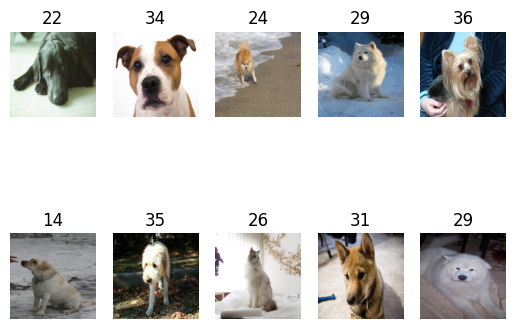

In [12]:
show_samples(dataset)

### 2.4 Species: Cat vs. Dog

In [17]:
import ssl
import os
from PIL import Image

from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import random_split, DataLoader, Dataset

#### 2.4.1 Make our own custom dataset for species

In [18]:
class CustomPetDataset(Dataset):
    """A customized dataset pets based on species.
    
    Oxford-IIIT Pets dataset is based on breeds.
    This class, convenrts that dataset to a species-based
    one, using `annotations/list.txt` file.
    """
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_dir = os.path.join(root, "images")
        list_txt_path = os.path.join(root, "annotations", "list.txt")
        self.samples = []

        with open(list_txt_path, "r") as f:
            for line in f:
                if line.startswith("#"):
                    # do not consider headers
                    continue
                parts = line.strip().split()
                filename = parts[0] + ".jpg"
                species = int(parts[2])  # 1=dog, 2=cat
                label = 1 if species == 1 else 0  # 1=dog, 0=cat
                self.samples.append((filename, label))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        filename, label = self.samples[idx]
        img_path = os.path.join(self.image_dir, filename)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

#### 2.4.2 Load data into new dataset class

In [20]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
])

dataset = CustomPetDataset(root="../data/oxford-iiit-pet", transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dl, test_dl


(<torch.utils.data.dataloader.DataLoader at 0x14c3953d900>,
 <torch.utils.data.dataloader.DataLoader at 0x14c39555de0>)

#### 2.4.3 Image Sapmles

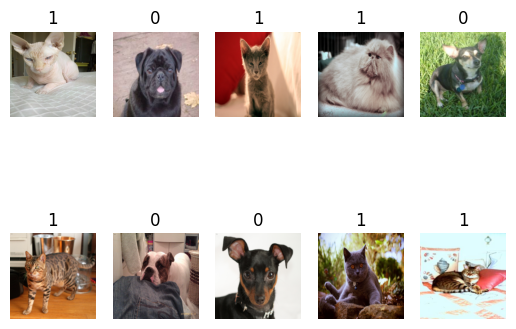

In [25]:
show_samples(dataset)